## CNN with Dropout and Data augmentation

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras.models import Sequential
from datetime import datetime 
from keras import optimizers
from keras.optimizers import SGD

In [4]:
# define parameters
batch_size = 32 
epochs = 10 
img_height = 180 
img_width = 180 

#path
path = 'archive-2/architectural-styles-dataset'

In [24]:
# for log
log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Use a summary writer to save the hyperparameters
with tf.summary.create_file_writer(log_dir).as_default():
  # tf.summary.scalar('learning_rate', data=learning_rate, step=0)
  tf.summary.scalar('batch_size', data=batch_size, step=0)
  tf.summary.scalar('num_epochs', data=num_epochs, step=0)

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=123,          # 123 is aribtary, could be any integer. 
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 10113 files belonging to 25 classes.
Using 8091 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    path, 
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width), 
    batch_size=batch_size
)

Found 10113 files belonging to 25 classes.
Using 2022 files for validation.


In [7]:
# class_names
class_names = train_ds.class_names
print(class_names)

['Achaemenid architecture', 'American Foursquare architecture', 'American craftsman style', 'Ancient Egyptian architecture', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture', 'Bauhaus architecture', 'Beaux-Arts architecture', 'Byzantine architecture', 'Chicago school architecture', 'Colonial architecture', 'Deconstructivism', 'Edwardian architecture', 'Georgian architecture', 'Gothic architecture', 'Greek Revival architecture', 'International style', 'Novelty architecture', 'Palladian architecture', 'Postmodern architecture', 'Queen Anne architecture', 'Romanesque architecture', 'Russian Revival architecture', 'Tudor Revival architecture']


### Visualize the data

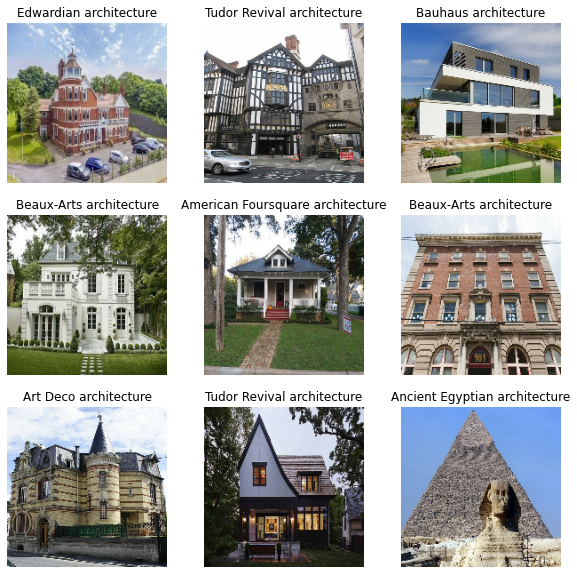

In [8]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


### Configure the dataset for performance 


In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# These lines speeds up the training process. Caching ensures that we don't have to reload the data every time we use it.
# Prefetching ensures that we always have the next batch of data ready to go. 

### Standardize the data 

In [10]:
normalization_layer = layers.Rescaling(1./255)

### Create model

In [11]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer=SGD(learning_rate=0.01), #previous: 'adam';
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #  need to check if another one is better. 
              metrics = ['accuracy'],
              )

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train model

In [14]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tensorboard_callback] # to keep track of log 
)

Epoch 1/10
253/253 [==============================] - 117s 409ms/step - loss: 2.9932 - accuracy: 0.1295 - val_loss: 2.7390 - val_accuracy: 0.1790
Epoch 2/10
253/253 [==============================] - 97s 384ms/step - loss: 2.4880 - accuracy: 0.2599 - val_loss: 2.5046 - val_accuracy: 0.2527
Epoch 3/10
253/253 [==============================] - 89s 352ms/step - loss: 2.0255 - accuracy: 0.3935 - val_loss: 2.3900 - val_accuracy: 0.2799
Epoch 4/10
253/253 [==============================] - 91s 360ms/step - loss: 1.4920 - accuracy: 0.5455 - val_loss: 2.4994 - val_accuracy: 0.3002
Epoch 5/10
253/253 [==============================] - 97s 382ms/step - loss: 0.8334 - accuracy: 0.7484 - val_loss: 3.0611 - val_accuracy: 0.2972
Epoch 6/10
253/253 [==============================] - 92s 365ms/step - loss: 0.3278 - accuracy: 0.9114 - val_loss: 3.8706 - val_accuracy: 0.2774
Epoch 7/10
253/253 [==============================] - 89s 351ms/step - loss: 0.1196 - accuracy: 0.9745 - val_loss: 4.5508 - val_a

### Visualize training results

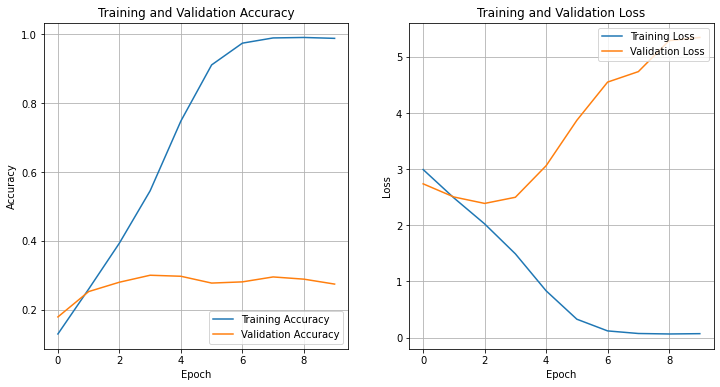

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot accuracy
axs[0].plot(epochs_range, acc, label='Training Accuracy')
axs[0].plot(epochs_range, val_acc, label='Validation Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].grid(True)

# Plot loss
axs[1].plot(epochs_range, loss, label='Training Loss')
axs[1].plot(epochs_range, val_loss, label='Validation Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend(loc='upper right')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].grid(True)

plt.show()

Only around 30 % accuracy. Sign of overfitting, since the training accuacy increase linarly in time, but the validation accuracy is around 30 % for a long time. We can use transfer learning, add dropout and data augumentation. 

### Data augmentation

In [17]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    #layers.RandomBrightness(0.1),
    #layers.RandomContrast(0.1)  # unsure how big effect contrast and brightness has(??)
]  
)
# Here we can add a lot more of them and see what works best.

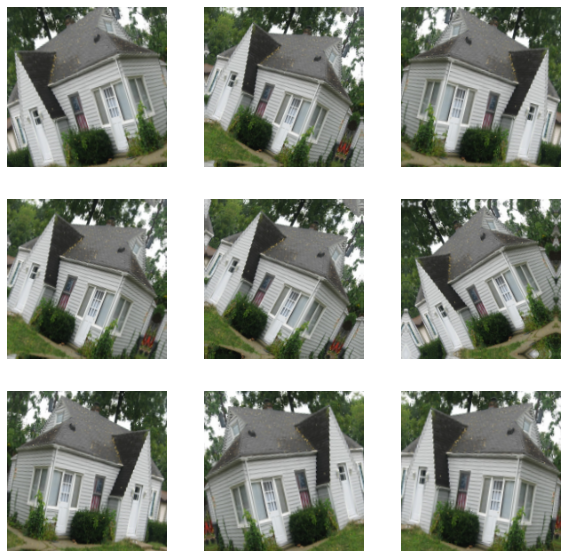

In [18]:
# visulaize a random image with data augmentaion 
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create a new model with dropout using the augmented data

In [19]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [20]:
# Compile and train model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tensorboard_callback] # to keep track of log 
)

Epoch 1/15
253/253 [==============================] - 103s 401ms/step - loss: 3.0338 - accuracy: 0.1104 - val_loss: 2.8582 - val_accuracy: 0.1330
Epoch 2/15
253/253 [==============================] - 100s 395ms/step - loss: 2.7574 - accuracy: 0.1800 - val_loss: 2.8362 - val_accuracy: 0.1820
Epoch 3/15
253/253 [==============================] - 1331s 5s/step - loss: 2.5546 - accuracy: 0.2366 - val_loss: 2.6446 - val_accuracy: 0.2201
Epoch 4/15
253/253 [==============================] - 108s 425ms/step - loss: 2.4019 - accuracy: 0.2738 - val_loss: 2.3816 - val_accuracy: 0.2948
Epoch 5/15
253/253 [==============================] - 103s 408ms/step - loss: 2.2943 - accuracy: 0.3027 - val_loss: 2.3995 - val_accuracy: 0.2770
Epoch 6/15
253/253 [==============================] - 105s 417ms/step - loss: 2.2291 - accuracy: 0.3230 - val_loss: 2.4156 - val_accuracy: 0.2794
Epoch 7/15
253/253 [==============================] - 102s 405ms/step - loss: 2.1536 - accuracy: 0.3452 - val_loss: 2.4128 - v

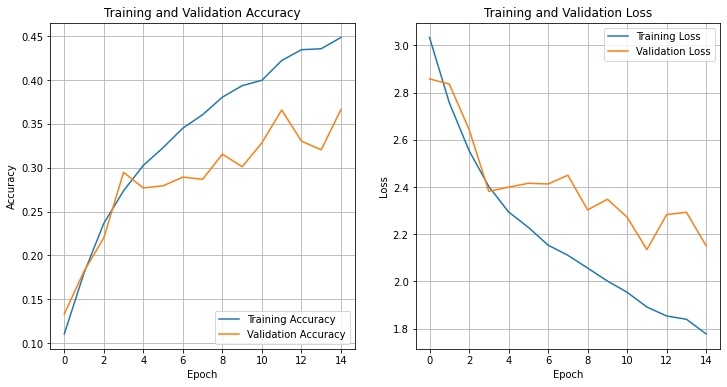

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot accuracy
axs[0].plot(epochs_range, acc, label='Training Accuracy')
axs[0].plot(epochs_range, val_acc, label='Validation Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].grid(True)

# Plot loss
axs[1].plot(epochs_range, loss, label='Training Loss')
axs[1].plot(epochs_range, val_loss, label='Validation Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend(loc='upper right')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].grid(True)

plt.show()

More equal results, but need to find the best dropout and augmentations. 
And use transfer learning. 
